<a href="https://colab.research.google.com/github/MLGlobalHealth/StatML4PopHealth/blob/main/assessments/groupwork_instruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/imperial.png" width="250" vspace="8"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/mlgh.png" width="220" hspace="50" vspace="5"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/ammi.png" width="190"/>

<font size="6">Modern Statistics and Machine Learning<br> for Population Health in Africa </font>

<font size="4">24th - 28th March 2025</font>

</center>

## Contributions:
### By Contribution

| Contribution | Name |
|---|---|
| xx | xx |


## Data

Today we are going to consider an air pollution data set for eight cities in seven African countries, Lagos, Accra, Nairobi, Yaounde, Bujumbura, Kisumu, Kampala, and Gulu. [Especially, fine particulate matter (PM2.5) of 2.5 microns or less in diameter are linked to poor health outcomes and millions of premature deaths globally](https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196(24)00003-2/fulltext). [In the UK, PM2.5 emissions have decreased by $>85\%$ since 1970](https://www.gov.uk/government/statistics/emissions-of-air-pollutants/emissions-of-air-pollutants-in-the-uk-particulate-matter-pm10-and-pm25), but in many other parts of the world PM2.5 emissions have increased to extremely dangerous levels.

PM2.5 are most accurately measured through low-cost on-the-ground sensor networks, but these are expensive. [We will focus on predicting PM2.5 concentrations using satellite-derived PM2.5 data that are themselves derived from Aerosol Optical Depth (AOD) measurements of the Sentinel 5P satellite instrument, available through the Google Earth Data Catalogue.](https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p)

In fact, many different atmospheric variables are measured and can be used as features to predict PM2.5 concentrations to empower communities to access crucial air quality information, provide them with the evidence needed to tackle local pollution challenges, and improve public health. The data that we consider today were previously used as part of a [prediction challenge](https://zindi.africa/competitions/airqo-african-air-quality-prediction-challenge/data) to support the [Clean Africa Air network](https://www.airqo.net).

For our purposes today, we will only use the noisy satellite-based PM2.5 measurements to predict actual, daily average PM2.5 concentrations using GP methodology. We will also focus on a single location to simplify matters. Our main objective is to estimate the number of days in a full year that PM2.5 concentrations were unhealthy above 35 μg/m3, [posing a significant risk to the general population as per WHO guidelines](https://www.who.int/publications/i/item/9789240034228).

In [1]:
# Install CmdStanPy for Google Colab
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/scripts/utilities.py"
from utilities import custom_install_cmdstan, test_cmdstan_installation
custom_install_cmdstan()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2066  100  2066    0     0   5470      0 --:--:-- --:--:-- --:--:--  5465
Installing cmdstanpy==1.2.5
Unpacking colab-cmdstan-2.36.0.tar.gz
Installing required libtbb2 Linux package
Setting cmdstan path
CmdStan successfully installed!


In [2]:
import os
import pickle
from pathlib import Path

import arviz as az
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
import folium
from datetime import timedelta,datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Aesthetics
sns.set_theme(style="whitegrid")
font = {"family": "sans-serif",
        "weight": "normal",
		"size": 10.5}
mpl.rc('font', **font)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
output_dir = Path(*["drive", "MyDrive", "short_course", "output"])
output_dir.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


In [4]:
# get the input data
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/data/sentinel_5p_particulate_matter.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6896k  100 6896k    0     0   9.8M      0 --:--:-- --:--:-- --:--:--  9.8M


## Select and explore PM2.5 data

Let us load and have a look at the satellite-based data of atmospheric variables in the eight cities:


In [5]:
# put WHO classification of PM2_5 health risks into table
dwho = {
    'risk': ['good','moderate','unhealthy for sensitive groups','unhealthy','very unhealthy'],
    'pm25_low': [0, 10, 25, 35, 55],
    'pm25_high': [10, 25, 35, 55,1000],
    'text': ['good air quality',
             'acceptable for short-term exposure but may affect sensitive groups over long-term exposure',
             'increased risk for vulnerable populations such as children, elderly, and people with pre-existing health conditions',
             'significant risk to the general population, especially with prolonged exposure',
             'severe health risk to the general public']
}
dwho = pd.DataFrame(dwho)
dwho

,risk,pm25_low,pm25_high,text
0,good,0,10,good air quality
1,moderate,10,25,acceptable for short-term exposure but may aff...
2,unhealthy for sensitive groups,25,35,increased risk for vulnerable populations such...
3,unhealthy,35,55,"significant risk to the general population, es..."
4,very unhealthy,55,1000,severe health risk to the general public


In [6]:
# load data
db = pd.read_csv("sentinel_5p_particulate_matter.csv")
db.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,...,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-08,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.537600
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,...,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731


This is very rich data. We will subset this to Kampala, the capital of Uganda with about 7 million people in the wider metropolitan area. The name Kampala goes back to the hill of the impala, a particular anthilope species that were once grazing there in large numbers. Let us plot the locations for which atmospheric variables are available:

In [7]:
#	subset to Kampala, Uganda
dp_kampala = db.loc[db['city'] == "Kampala",['city', 'country', 'date', 'hour', 'site_id', 'site_latitude', 'site_longitude', 'pm2_5']]
dp_kampala['date'] = pd.to_datetime(dp_kampala['date'], format = '%Y-%m-%d')
dp_kampala['year'] = dp_kampala['date'].dt.strftime('%Y')
dp_kampala['month'] = dp_kampala['date'].dt.strftime('%m')
dp_kampala.head()


,city,country,date,hour,site_id,site_latitude,site_longitude,pm2_5,year,month
202,Kampala,Uganda,2023-05-11,10,60d058c8048305120d2d6147,0.3075,32.6206,8.7256,2023,05
203,Kampala,Uganda,2023-06-07,12,60d058c8048305120d2d6147,0.3075,32.6206,8.9866,2023,06
204,Kampala,Uganda,2023-06-08,11,60d058c8048305120d2d6147,0.3075,32.6206,7.2996,2023,06
205,Kampala,Uganda,2023-06-09,11,60d058c8048305120d2d6147,0.3075,32.6206,13.1901,2023,06
206,Kampala,Uganda,2024-01-24,11,60d058c8048305120d2d6147,0.3075,32.6206,30.9539,2024,01


In [8]:
# name sites and merge
dp_sites = dp_kampala.loc[:,['city', 'site_id','site_latitude', 'site_longitude']].drop_duplicates()
dp_sites['site_name'] = ['site-' + str(i) for i in range(1,len(dp_sites)+1)]
dp_kampala = pd.merge(dp_kampala, dp_sites, on = ['city','site_id','site_latitude', 'site_longitude'])
dp_kampala.head()

,city,country,date,hour,site_id,site_latitude,site_longitude,pm2_5,year,month,site_name
0,Kampala,Uganda,2023-05-11,10,60d058c8048305120d2d6147,0.3075,32.6206,8.7256,2023,05,site-1
1,Kampala,Uganda,2023-06-07,12,60d058c8048305120d2d6147,0.3075,32.6206,8.9866,2023,06,site-1
2,Kampala,Uganda,2023-06-08,11,60d058c8048305120d2d6147,0.3075,32.6206,7.2996,2023,06,site-1
3,Kampala,Uganda,2023-06-09,11,60d058c8048305120d2d6147,0.3075,32.6206,13.1901,2023,06,site-1
4,Kampala,Uganda,2024-01-24,11,60d058c8048305120d2d6147,0.3075,32.6206,30.9539,2024,01,site-1


In [9]:
# Create a map showing measurement locations in Kampala
# coordinates for the center of Kampala
lat_kampala = 0.3136
lon_kampala = 32.5818

# create map
map = folium.Map(location=[lat_kampala, lon_kampala], zoom_start=12)

# Add markers for each site
for idx, row in dp_sites.iterrows():
    folium.Marker(
        location=[row['site_latitude'], row['site_longitude']],
        popup=row['site_name']
    ).add_to(map)

# Sace and display  the map
map.save(output_dir.joinpath("kampala_map.html"))
map

Let us plot the time series of the noisy PM2.5 measurements in two sites:

In [10]:
# Select specific sites and rename them
dp = dp_kampala[dp_kampala['site_name'].isin(['site-4', 'site-9'])]
dp.loc[:,['site_name']] = dp['site_name'].replace({'site-4': 'Buwate', 'site-9': 'Kyebando'})
dp

,city,country,date,hour,site_id,site_latitude,site_longitude,pm2_5,year,month,site_name
394,Kampala,Uganda,2023-01-01,11,616fe4ce9657420029658b3e,0.40532,32.62027,13.7318,2023,01,Buwate
395,Kampala,Uganda,2023-01-02,10,616fe4ce9657420029658b3e,0.40532,32.62027,12.2671,2023,01,Buwate
396,Kampala,Uganda,2023-01-03,10,616fe4ce9657420029658b3e,0.40532,32.62027,14.1832,2023,01,Buwate
397,Kampala,Uganda,2023-01-04,11,616fe4ce9657420029658b3e,0.40532,32.62027,14.6162,2023,01,Buwate
398,Kampala,Uganda,2023-01-05,11,616fe4ce9657420029658b3e,0.40532,32.62027,12.0140,2023,01,Buwate
...,...,...,...,...,...,...,...,...,...,...,...
1337,Kampala,Uganda,2024-02-12,10,60d058c8048305120d2d615c,0.35640,32.57300,31.8975,2024,02,Kyebando
1338,Kampala,Uganda,2024-02-13,11,60d058c8048305120d2d615c,0.35640,32.57300,52.2077,2024,02,Kyebando
1339,Kampala,Uganda,2024-02-24,11,60d058c8048305120d2d615c,0.35640,32.57300,31.7259,2024,02,Kyebando
1340,Kampala,Uganda,2024-02-25,11,60d058c8048305120d2d615c,0.35640,32.57300,91.1076,2024,02,Kyebando


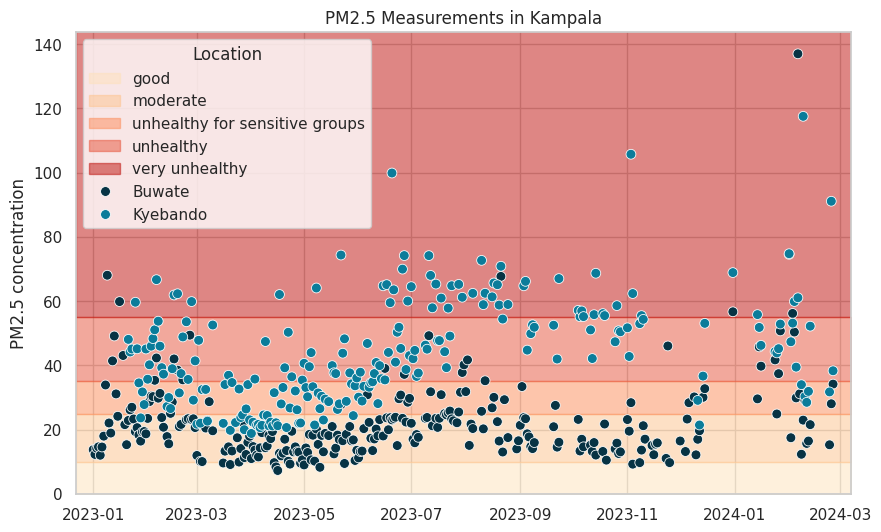

In [11]:
plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette(["#073344FF", "#0B7C9AFF"])

# Create a rectangle for the WHO PM2.5 range
for _, row in dwho.iterrows():
    plt.fill_between(
        [dp['date'].min() - timedelta(days=10), dp['date'].max() + timedelta(days=10)],
        row['pm25_low'], row['pm25_high'],
        color=sns.color_palette("OrRd", len(dwho))[_], alpha=0.5, label=row['risk']
    )
# Plot PM2.5 data points
sns.scatterplot(
    data=dp, x='date', y='pm2_5', hue='site_name', palette=custom_palette, s=50
)

# Customizing the plot
plt.xlim([dp['date'].min() - timedelta(days=10), dp['date'].max() + timedelta(days=10)])
plt.ylim([0, max(dp['pm2_5']) * 1.05])
plt.xlabel('')
plt.ylabel('PM2.5 concentration')
plt.title('PM2.5 Measurements in Kampala')
plt.legend(title='Location')

## Non-parametric modelling with GPs

Let us denote by $y_i$ the PM2.5 concentrations in the $i$th observation.

We model $y_i$ with
\begin{align*}
& y_i \sim \text{LogNormal}(\mu_i, \sigma^2) \\
& \mu_i = \beta_0 + f(\text{date}_i) \\
& \beta_0 \sim \text{Normal}(0, 2) \\
& f \sim \text{GP}(0,k) \\
\end{align*}
where the median is $\exp(\mu_i)$, the mean is $\exp(\mu_i + \sigma^2/2)$, the variance is
$(\exp(\sigma^2)-1)exp(2\mu_i + \sigma^2)$, and $f$ is a random function that is
evaluated using dates as inputs and so captures time effects non-parametrically. The random function is given a zero-mean GP prior with squared exponential kernel with GP variance $\alpha$ and lengthscale $\rho$.
We specify hyper-priors by
\begin{align*}
& \alpha \sim \text{Half-Cauchy}(0, 1) \\
& \rho \sim \text{Inv-Gamma}(5, 1) \\
& \sigma \sim \text{Half-Cauchy}(0,1)
\end{align*}
The hyperparameters $\alpha$, $\rho$ are given default priors that are suitable for a standardised input domain $[0,1]$.

Below is the `Stan` model file, [based on the Stan v2.36.0 manual](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#predictive-inference-with-a-gaussian-process).

Note how the variance to mean ratio in the LogNormal scales exponentially with $\sigma^2$, and for this reason
one typically attaches priors with relatively limited variance to the baseline parameter when compared
to other observation likelihood models.

Note that the joint distribution of $f$ evaluated at a finite set of inputs is just a multivariate normal, and so we can straightforwardly generate samples from $f$ through linear transformation of iid standard normal random variables (through the line $f = L_f * z$).

## Group Project Instructions

### Objective
The goal of this group project is to analyze air pollution data from a selected site using a Gaussian Process (GP) model with Hilbert Space approximation. The primary objective is to estimate the number of days in a year that PM2.5 concentrations were at unhealthy level (above 35 $\mu$g/$m^3$).

-----
### Tasks

#### 1. Site Selection
Select **one site** from Kampala city. Make sure that there are not too many missing values.

#### 2. Model Implementation
Implement the **Gaussian Process (GP) model** as specified in the previous section, using **Hilbert Space approximation**. You can also consider changing kernel from squared exponential to, for example, matern class kernel (Optional).  

#### 3. Model Diagnostics
Evaluate **convergence and mixing** of the Markov Chain Monte Carlo (MCMC) algorithm.  
- Obtain summary statistics, including **Rhat** and **Effective sample size (ESS)**.
- Since there may be many parameters, focus on the **trace plot of the model parameter with the lowest effective sample size**.
- Note there may be a few divergent transitions, but for the purpose of this project, you may proceed to next steps if they are deemed satisfactory.

#### 4. Visualization
- Plot the **posterior median of the target variable (PM2.5 concentration)** over time.
- Include 95% credible intervals to visualize variability.

#### 5. Answer the Main Objective
- Calculate the number of days in a full year that the level of PM2.5 concentrations were unhealthy above $35 \mu g / m^3$.
- Summarize your findings and interpret the results in the context of public health.


### 6. Additional Sites (Optional)
- If time permits, **repeat the analysis for a few additional sites**.
- Compare the results across sites and discuss any spatial patterns or variability.

-----

### Deliverables
Prepare a short presentation with slides highlighting tasks achieved, with a focus on the results and conclusions of your analysis. Each group member should present for at least 2-3 minutes to ensure balanced participation. Submit your python notebook, one per group. Marks are available for achieving the different tasks in 1-6 (group mark), and contents and delivery of the presentation (individual mark).

## 1. Site Selection
First we will look at all the sites in Kampala, evaluating which are missing data to see which are suitable candidates.

In [36]:

sites_raw = dp_kampala[['site_name','date','pm2_5']].groupby(['site_name']).count().sort_values(by='date',ascending=False)
sites = pd.DataFrame(sites_raw)
sites


,date,pm2_5
site_name,,
site-20,288,288
site-13,284,284
site-22,283,283
site-4,282,282
site-25,275,275
site-10,273,273
site-26,263,263
site-2,260,260
site-21,260,260


In [37]:
dp_kampala['date'].min()

Timestamp('2023-01-01 00:00:00')

In [38]:
dp_kampala['date'].max()

Timestamp('2024-02-26 00:00:00')

This is just over a year's worth of data, if there is one value for each day, we would expect about 400 values. The top sites have ~290 values, that's a lot of missing values.

In [41]:
site_candidates_raw = dp_kampala[['site_name','date','pm2_5']]
site_candidates = site_candidates_raw.loc[(site_candidates_raw['site_name']=='site-20')|(site_candidates_raw['site_name']=='site-13')|(site_candidates_raw['site_name']=='site-22')|(site_candidates_raw['site_name']=='site-4')]
site_candidates

,site_name,date,pm2_5
394,site-4,2023-01-01,13.7318
395,site-4,2023-01-02,12.2671
396,site-4,2023-01-03,14.1832
397,site-4,2023-01-04,14.6162
398,site-4,2023-01-05,12.0140
...,...,...,...
4154,site-22,2024-02-13,16.3141
4155,site-22,2024-02-23,9.1853
4156,site-22,2024-02-24,8.4066
4157,site-22,2024-02-25,20.3713


In [42]:
fig = px.line(site_candidates,  x='date', y='pm2_5', color='site_name')
fig.show()

Site 20 has an interesting pattern, so we will use that for demonstration.

In [43]:
# This code allows us to choose any site from the data

def get_available_sites(df):
  site_list = df['site_name'].unique()
  return site_list

def print_site_list(site_list):
  print('Available sites are:')
  for site in site_list:
    print(site)
  return

def select_site(site_list):
  site_name = input('Please select a site from the list: ')
  if site_name in site_list:
    return site_name
  else:
    print(f'Invalid site name. Please select a valid option from {site_list}')
    return select_site(site_list)

def get_one_site(df, site_name):
  return df.loc[df['site_name']==site_name]

def choose_site(df):
  site_list = get_available_sites(df)
  print_site_list(site_list)
  selected_site = select_site(site_list)
  selected_site_df = get_one_site(df, selected_site)
  return selected_site_df

In [ ]:
# This code lets us choose any city and evaluates suitable site candidates
def

In [44]:
site_list = get_available_sites(dp_kampala)
print_site_list(site_list)
selected_site = select_site(site_list)
selected_site_df = get_one_site(dp_kampala, selected_site)
selected_site_df

Available sites are:
site-1
site-2
site-3
site-4
site-5
site-6
site-7
site-8
site-9
site-10
site-11
site-12
site-13
site-14
site-15
site-16
site-17
site-18
site-19
site-20
site-21
site-22
site-23
site-24
site-25
site-26
site-27
site-28
site-29
site-30
Please select a site from the list: site-20


,city,country,date,hour,site_id,site_latitude,site_longitude,pm2_5,year,month,site_name
3328,Kampala,Uganda,2023-01-01,11,620dd7ce72eb9200299fb8c1,0.29282,32.57132,18.8872,2023,01,site-20
3329,Kampala,Uganda,2023-01-02,10,620dd7ce72eb9200299fb8c1,0.29282,32.57132,20.8391,2023,01,site-20
3330,Kampala,Uganda,2023-01-03,10,620dd7ce72eb9200299fb8c1,0.29282,32.57132,21.8550,2023,01,site-20
3331,Kampala,Uganda,2023-01-04,11,620dd7ce72eb9200299fb8c1,0.29282,32.57132,20.2593,2023,01,site-20
3332,Kampala,Uganda,2023-01-05,11,620dd7ce72eb9200299fb8c1,0.29282,32.57132,22.0323,2023,01,site-20
...,...,...,...,...,...,...,...,...,...,...,...
3611,Kampala,Uganda,2024-02-11,10,620dd7ce72eb9200299fb8c1,0.29282,32.57132,14.2353,2024,02,site-20
3612,Kampala,Uganda,2024-02-12,10,620dd7ce72eb9200299fb8c1,0.29282,32.57132,12.5999,2024,02,site-20
3613,Kampala,Uganda,2024-02-13,11,620dd7ce72eb9200299fb8c1,0.29282,32.57132,12.9186,2024,02,site-20
3614,Kampala,Uganda,2024-02-25,11,620dd7ce72eb9200299fb8c1,0.29282,32.57132,21.8379,2024,02,site-20


### Tips / Hints

* To select a site that is a good fit for the project, it's useful to plot all time series. Try following code
```
fig = px.line(dp_all,  x='date', y='pm2_5', color='site_name')
fig.show()
```
Choose a location where the first and last observations are more than 1 year apart, and not too many missing values in between. Use **all** observations available in the model fitting phase.
* You will have to obtain GP predictions on the days where the response variable (MP2.5 level) is not recorded.
* You can use `log_normal`, `lognormal_rng` functions to specify log normal likelihood or sample from log normal distribution. You can also see [Stan manual](`https://mc-stan.org/docs/2_21/functions-reference/lognormal.html`).

We will show data processing step below. In this example, we focus on 'site-9'


In [ ]:
dp = dp_kampala[dp_kampala['site_name'] == 'site-9'].sort_values(by=['date'])
print('The number of observation:', len(dp),'between', (dp['date'].min()).strftime('%d %B, %Y') , 'and', (dp['date'].max()).strftime('%d %B, %Y'))

At the selected site, we have 229 observations during the period of 402 days
(from 21 January, 2023 to 26 February, 2024). We fit the GP model to these 229 points, and make prediction on the rest of the days (173 days). This can be done in `generated quantities` block

Let's prepare the data. We want to standardize the variable $t$, which represents the date. Let $k_i$ denote the unstandardized day variable, ranging from 1 to 402 in this example.

To standardize $t$, it is common practice to use only the observed (training) data when calculating the mean ($m$) and standard deviation ($s$). This means that in the standardized variable, given by $t_i = (k_i - m ) / s$, $m$ and $s$ are calculated exclusively from the observed data, ensuring that the standardization process does not incorporate any information from the validation or test sets.

In [17]:
# converting the date to start from 1
day_num = (dp.date - min(dp.date)).dt.days + 1.0
# get mean and standard diviation
mean_day = day_num.mean()
std_day = day_num.std()

Let's use this in `dp`

In [18]:
dp.loc[:,['day']] = day_num
dp.loc[:,['day_std']] = (dp['day'] - mean_day) / std_day

Now we can create a new DataFrame to include the remaining days that are not present in the `dp` DataFrame.

In [19]:
# create df with all dates (converted date, which we call day)
dp_all ={
    'date' : [dp.date.min() + timedelta(days=x) for x in range((dp.date.max()-dp.date.min()).days + 1)],
    'day' : range(1, (dp.date.max()-dp.date.min()).days + 2),
}
dp_all = pd.DataFrame(dp_all)
# standardise `day` using mean and srandard diviation we calculated in the previous step
dp_all['day_std'] = (dp_all['day'] - mean_day) / std_day
# datafrmame for days without observation
dp_new = dp_all[~dp_all['day'].isin(day_num)].sort_values(by=['date'])

Then we have all data we need to provide to `Stan` model, but we will create a dataframe which combine both data.

In [20]:
dp.loc[:,['source']] = 'obs'
dp_new.loc[:,['source']] = 'pred'
dp_all = pd.concat([dp[['pm2_5','date','day','day_std','source']], dp_new], axis=0).sort_values(by=['date'])

Text(0.5, 1.0, 'PM2.5 Measurements in Kampala')

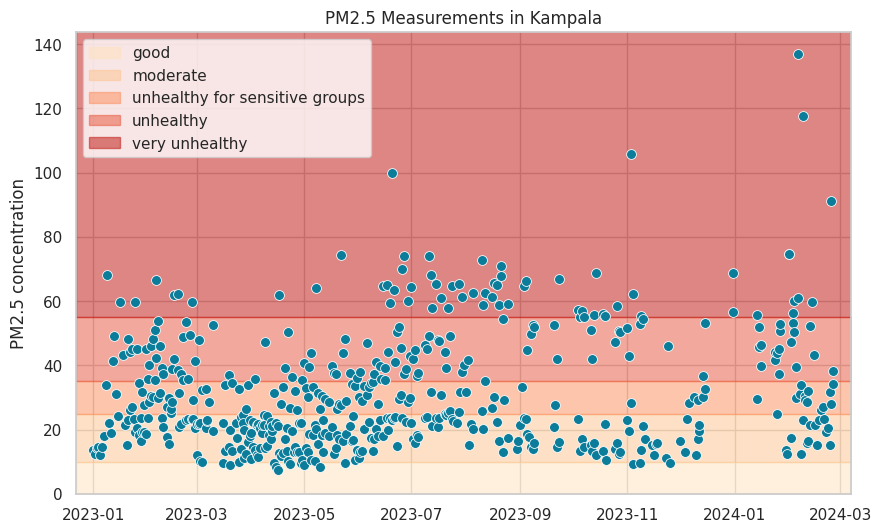

In [21]:
plt.figure(figsize=(10, 6))

# Create a rectangle for the WHO PM2.5 range
for _, row in dwho.iterrows():
    plt.fill_between(
        [dp['date'].min() - timedelta(days=10), dp['date'].max() + timedelta(days=10)],
        row['pm25_low'], row['pm25_high'],
        color=sns.color_palette("OrRd", len(dwho))[_], alpha=0.5, label=row['risk']
    )
# Plot PM2.5 data points
sns.scatterplot(
    data= dp_all, x='date', y='pm2_5', s=50, color = "#0B7C9AFF"
)
# Customizing the plot
plt.xlim([dp['date'].min() - timedelta(days=10), dp['date'].max() + timedelta(days=10)])
plt.ylim([0, max(dp['pm2_5']) * 1.05])
plt.xlabel('')
plt.ylabel('PM2.5 concentration')
plt.title('PM2.5 Measurements in Kampala')